In [1]:
import pandas as pd
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# 한글 설정
plt.rcParams['font.family'] = 'Nanum Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 로딩
sales_files = glob.glob('/Users/giwonjun/Desktop/boot/02_proj_ML/SKN13-2nd-4TEAM/data/expected_sales/*.csv')
shops_files = glob.glob('/Users/giwonjun/Desktop/boot/02_proj_ML/SKN13-2nd-4TEAM/data/the_number_of_shops/*.csv')

sales_df = pd.concat([pd.read_csv(file) for file in sales_files], ignore_index=True)
shops_df = pd.concat([pd.read_csv(file) for file in shops_files], ignore_index=True)

In [2]:
# 2. 매출/점포수 기반 평균 매출 파생변수용 필터
relevant_columns = [
    '기준_년분기_코드', '상권_구분_코드', '상권_구분_코드_명',
    '상권_코드', '상권_코드_명', '서비스_업종_코드', '서비스_업종_코드_명', '당월_매출_금액'
]
sales_avg = sales_df[relevant_columns].copy()

In [3]:
# 3. 연도 추출
def extract_year(code):
    return int(str(code)[:4])

sales_df['연도'] = sales_df['기준_년분기_코드'].apply(extract_year)
shops_df['연도'] = shops_df['기준_년분기_코드'].apply(extract_year)

# 4. 전년도-다음년도 병합을 위한 key 설정
merge_keys = ['상권_코드', '서비스_업종_코드', '상권_구분_코드']

In [4]:
# 5. 병합 함수 정의 (두 연도간 비교)
def merge_year_pairs(df, year1, year2, value_col, suffix1='_prev', suffix2=''):
    df1 = df[df['연도'] == year1][merge_keys + [value_col]].copy()
    df2 = df[df['연도'] == year2][merge_keys + [value_col]].copy()
    df1 = df1.rename(columns={value_col: value_col + suffix1})
    df2 = df2.rename(columns={value_col: value_col + suffix2})
    return pd.merge(df1, df2, on=merge_keys, how='inner')

In [5]:
# 6. 점포수 증감률 계산 (20~21, 21~22, 22~23)
shop_change = pd.DataFrame()
sales_change = pd.DataFrame()
for (y1, y2) in [(2020, 2021), (2021, 2022), (2022, 2023)]:
    # 점포수 증감률
    shop_pair = merge_year_pairs(shops_df, y1, y2, '점포_수')
    shop_pair['기준연도'] = y2
    shop_pair['점포수_증감률'] = (shop_pair['점포_수'] - shop_pair['점포_수_prev']) / shop_pair['점포_수_prev']
    shop_change = pd.concat([shop_change, shop_pair], ignore_index=True)

    # 매출액 증감률
    sales_pair = merge_year_pairs(sales_df, y1, y2, '당월_매출_금액')
    sales_pair['기준연도'] = y2
    sales_pair['매출액_증감률'] = (sales_pair['당월_매출_금액'] - sales_pair['당월_매출_금액_prev']) / sales_pair['당월_매출_금액_prev']
    sales_change = pd.concat([sales_change, sales_pair], ignore_index=True)

# 병합: 증감률 포함
merged = pd.merge(shop_change, sales_change, on=merge_keys + ['기준연도'], how='inner')

In [6]:
# 7. 평균 매출 계산
avg_sales = sales_df.groupby(['연도'] + merge_keys)['당월_매출_금액'].sum().reset_index()
avg_shops = shops_df.groupby(['연도'] + merge_keys)['점포_수'].sum().reset_index()

avg = pd.merge(avg_sales, avg_shops, on=['연도'] + merge_keys, how='inner')
avg['평균매출_점포당'] = avg['당월_매출_금액'] / avg['점포_수']

In [7]:
# 8. 폐업률
close_rate = shops_df[['연도'] + merge_keys + ['폐업_점포_수', '점포_수']]
close_rate = close_rate.groupby(['연도'] + merge_keys).sum().reset_index()
close_rate['폐업률'] = close_rate['폐업_점포_수'] / close_rate['점포_수']

In [8]:
# 9. 최종 병합
final = pd.merge(merged, avg, left_on=['기준연도'] + merge_keys, right_on=['연도'] + merge_keys, how='inner')
final = pd.merge(final, close_rate, left_on=['기준연도'] + merge_keys, right_on=['연도'] + merge_keys, how='inner')


In [14]:
# 10. 타겟 생성
threshold = 0.3
final['폐업여부'] = (final['폐업률'] >= threshold).astype(int)

In [12]:
# 11. 피처/타겟 분리
drop_cols = ['폐업_점포_수', '당월_매출_금액', '점포_수_prev', '점포_수', '폐업률', '연도_x', '연도_y', '연도']
# X = final.drop(columns=drop_cols + ['폐업여부'])
existing_cols = [col for col in drop_cols + ['폐업여부'] if col in final.columns]
X = final.drop(columns=existing_cols)
y = final['폐업여부']

# 문자열 인코딩
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# 결측치 처리
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)

# 스케일링
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# train/test 분리
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

In [13]:
# 12. 모델 정의 및 학습
models = {
    "RandomForest": RandomForestClassifier(random_state=42, n_estimators=100, warm_start=True),
    "LightGBM": LGBMClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

results = {}

for name, model in models.items():
    print(f"\n▶️ 모델 학습 시작: {name}")
    if name == "RandomForest":
        for i in tqdm(range(1, model.n_estimators + 1), desc=f"Training {name}"):
            model.set_params(n_estimators=i)
            model.fit(X_train, y_train)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n▶️ [{name}] Classification Report")
    print(classification_report(y_test, y_pred))
    print(f"▶️ [{name}] ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"✅ [{name}] Accuracy: {acc:.4f}")

# 성능 비교
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
print(f"\n📊 모델 성능 순위(threshold:{threshold}):")
for rank, (model_name, acc_val) in enumerate(sorted_results, 1):
    print(f"{rank}. {model_name}: {acc_val:.4f}")


▶️ 모델 학습 시작: RandomForest


Training RandomForest: 100%|██████████| 100/100 [37:38<00:00, 22.58s/it]



▶️ [RandomForest] Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    943181
           1       1.00      1.00      1.00    615411

    accuracy                           1.00   1558592
   macro avg       1.00      1.00      1.00   1558592
weighted avg       1.00      1.00      1.00   1558592

▶️ [RandomForest] ROC-AUC Score: 1.0000
✅ [RandomForest] Accuracy: 1.0000

▶️ 모델 학습 시작: LightGBM
[LightGBM] [Info] Number of positive: 5537373, number of negative: 8489955
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.100654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2367
[LightGBM] [Info] Number of data points in the train set: 14027328, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.394756 -> initscore=-0.427363
[LightGBM] [Info] Start 

/Users/giwonjun/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [13:13:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



▶️ [XGBoost] Classification Report
              precision    recall  f1-score   support

           0       0.83      0.88      0.86    943181
           1       0.80      0.72      0.76    615411

    accuracy                           0.82   1558592
   macro avg       0.81      0.80      0.81   1558592
weighted avg       0.82      0.82      0.82   1558592

▶️ [XGBoost] ROC-AUC Score: 0.8947
✅ [XGBoost] Accuracy: 0.8187


NameError: name 'threshold' is not defined


📈 RandomForest Feature Importance 시각화


/var/folders/69/bt3_5fns57n_cp5_ydbrhfh80000gn/T/ipykernel_27762/3624413009.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values[:top_k], y=feat_imp.index[:top_k], palette=colors[:top_k])
/var/folders/69/bt3_5fns57n_cp5_ydbrhfh80000gn/T/ipykernel_27762/3624413009.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Nanum Gothic.
  plt.tight_layout()
/Users/giwonjun/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Nanum Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


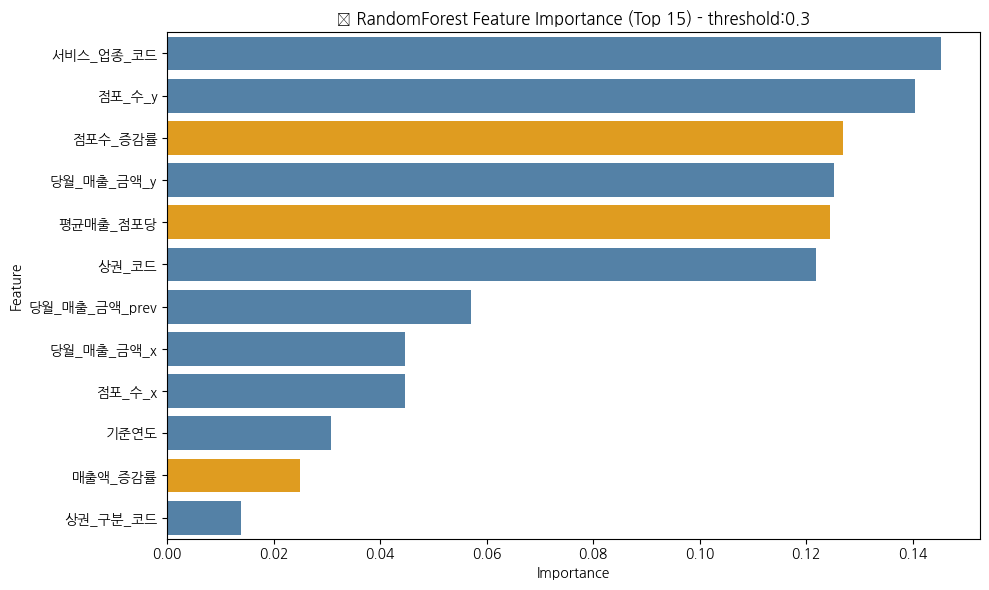

/var/folders/69/bt3_5fns57n_cp5_ydbrhfh80000gn/T/ipykernel_27762/3624413009.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values[:top_k], y=feat_imp.index[:top_k], palette=colors[:top_k])



📈 LightGBM Feature Importance 시각화


/var/folders/69/bt3_5fns57n_cp5_ydbrhfh80000gn/T/ipykernel_27762/3624413009.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Nanum Gothic.
  plt.tight_layout()
/Users/giwonjun/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Nanum Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


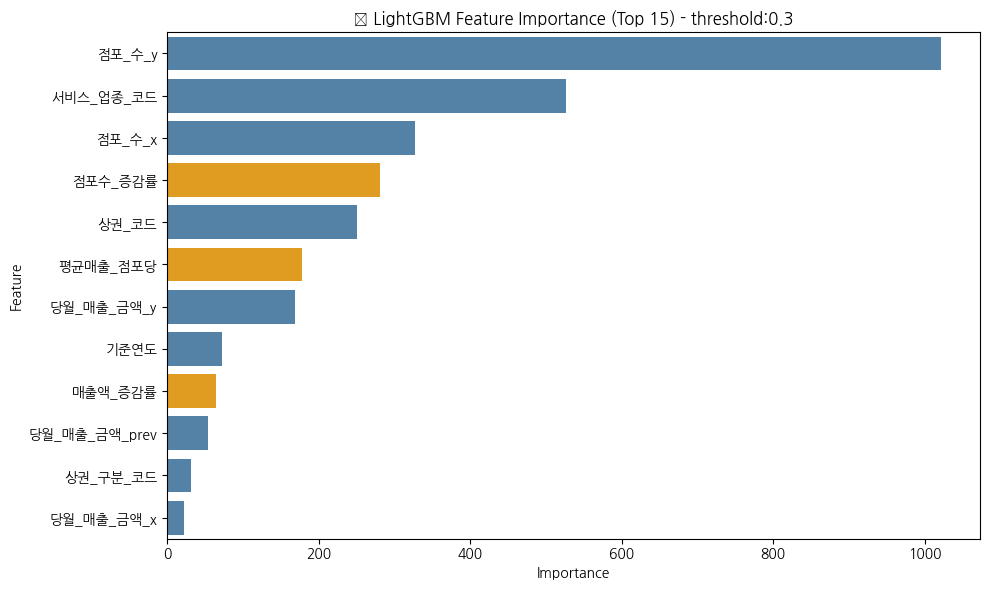


📈 XGBoost Feature Importance 시각화


/var/folders/69/bt3_5fns57n_cp5_ydbrhfh80000gn/T/ipykernel_27762/3624413009.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values[:top_k], y=feat_imp.index[:top_k], palette=colors[:top_k])
/var/folders/69/bt3_5fns57n_cp5_ydbrhfh80000gn/T/ipykernel_27762/3624413009.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Nanum Gothic.
  plt.tight_layout()
/Users/giwonjun/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Nanum Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


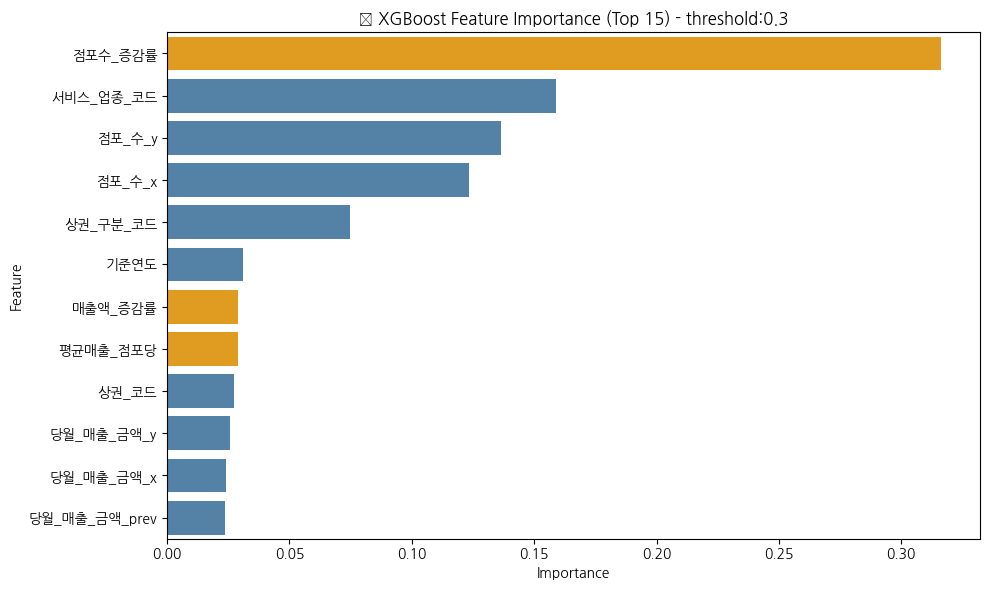

In [15]:
# 13. Feature Importance
def plot_feature_importance(importances, feature_names, model_name="Model"):
    feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    # 주요 파생 변수 강조 색상 지정
    highlight_features = ['점포수_증감률', '매출액_증감률', '평균매출_점포당']
    colors = ['orange' if f in highlight_features else 'steelblue' for f in feat_imp.index]

    # 상위 15개만 시각화
    top_k = 15
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feat_imp.values[:top_k], y=feat_imp.index[:top_k], palette=colors[:top_k])
    plt.title(f"📊 {model_name} Feature Importance (Top {top_k}) - threshold:{threshold}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

# 모델별 Feature Importance 시각화
for name, model in models.items():
    if hasattr(model, "feature_importances_"):
        print(f"\n📈 {name} Feature Importance 시각화")
        importances = model.feature_importances_
        feature_names = X.columns
        plot_feature_importance(importances, feature_names, model_name=name)
